In [1]:
%%capture
import sklearn # import before to get new version
import os
import site
site.addsitedir('/home/schirrmr/.local/lib/python2.7/site-packages/')
site.addsitedir('/usr/lib/pymodules/python2.7/')
os.sys.path.insert(0, '/home/schirrmr/braindecode/code/')
%cd /home/schirrmr/braindecode/code/braindecode/
assert 'THEANO_FLAGS' in os.environ
# switch to cpu
#os.environ['THEANO_FLAGS'] = 'floatX=float32,device=cpu,nvcc.fastmath=True'
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import theano
import theano.tensor as T
import lasagne

import matplotlib.pyplot as plt
%matplotlib inline

import gzip
import pickle

Using gpu device 0: GeForce GTX TITAN Black (CNMeM is disabled, CuDNN 3007)


In [3]:
train, val, test = pickle.load(gzip.open('data/mnist/mnist.pkl.gz'))

X_train, y_train = train
X_val, y_val = val

## Two digit

In [4]:
X_train_topo = X_train.reshape(X_train.shape[0], 28,28)
X_val_topo = X_val.reshape(X_val.shape[0], 28,28)

from numpy.random import RandomState

rng = RandomState(98787)
random_inds = range(len(X_train))
rng.shuffle(random_inds)

X_train_topo_both = np.concatenate([X_train_topo, X_train_topo[random_inds]], axis=2)
X_train_flat_both = X_train_topo_both.reshape(X_train_topo_both.shape[0],-1)
y_train_both = np.logical_or(y_train < 3, y_train[random_inds] < 3).astype(np.int32)
rng = RandomState(987837)
random_val_inds = range(len(X_val))
rng.shuffle(random_val_inds)
X_val_topo_both = np.concatenate([X_val_topo, X_val_topo[random_val_inds]], axis=2)
X_val_flat_both = X_val_topo_both.reshape(X_val_topo_both.shape[0],-1)
y_val_both = np.logical_or(y_val < 3, y_val[random_val_inds] < 3).astype(np.int32)

out_relevances = np.array([1 - y_train_both, y_train_both], dtype=np.float32).T

In [5]:
def compute_show_heatmaps(heatmap_fn, pred_fn, X_train_flat_both, X_train_topo_both, 
                          y_train_both, i_last_trial=20):
    all_preds = pred_fn(X_train_flat_both)
    preds_for_correct_class = np.array([all_preds[i, y_train_both[i]] for i in xrange(len(X_train_flat_both))])
    
    wanted_trials = np.flatnonzero(preds_for_correct_class > 0.95)[:i_last_trial]
    all_heatmaps = heatmap_fn( X_train_flat_both[wanted_trials])
    print("Mean Std over heatmaps: {:.1f}  ({:.1f})".format(np.mean(np.sum(all_heatmaps, axis=(1,2,3))), 
        np.std(np.sum(all_heatmaps, axis=(1,2,3)))))
    all_scaled_relevances = all_heatmaps.squeeze() * (
        np.std(X_train_topo_both[wanted_trials], axis=(1,2), keepdims=True) / 
        np.std(all_heatmaps.squeeze(), axis=(1,2), keepdims=True))
    plt.figure(figsize=(12,10))
    n_cols = 5
    n_rows = int(np.ceil(i_last_trial / float(n_cols))) * 2
    for i_plot in xrange(i_last_trial):
        scaled_relevance = all_scaled_relevances[i_plot]
        i_row = i_plot // n_cols
        plt.subplot(n_rows, n_cols, i_plot+1 + (i_row) * n_cols)
        trial = X_train_topo_both[wanted_trials][i_plot]
        together = np.array([scaled_relevance * (scaled_relevance > 0), 
                             trial*0.5,
                            scaled_relevance * (scaled_relevance < 0)]).transpose(1,2,0)
        plt.imshow(together, interpolation='nearest', vmin=-3*np.mean(np.abs(scaled_relevance)), 
                   vmax=+3*np.mean(np.abs(scaled_relevance)))
        plt.axis('off')
        plt.subplot(n_rows, n_cols, i_plot+1 + (i_row+1) * n_cols)
        scaled_relevance_red_blue = np.array([scaled_relevance * (scaled_relevance > 0), 
                             trial*0,
                            scaled_relevance * (scaled_relevance < 0)]).transpose(1,2,0)
        plt.imshow(scaled_relevance_red_blue, interpolation='nearest', vmin=-3*np.mean(np.abs(scaled_relevance)), 
                   vmax=+3*np.mean(np.abs(scaled_relevance)))
        plt.axis('off')

    plt.tight_layout()
    
    
from braindecode.experiments.experiment import Experiment
from braindecode.datasets.pylearn import DenseDesignMatrixWrapper
from braindecode.datahandling.splitters import SingleFoldSplitter
from braindecode.datahandling.batch_iteration import BalancedBatchIterator
from braindecode.veganlasagne.objectives import categorical_crossentropy
from lasagne.updates import adam
from braindecode.veganlasagne.monitors import LossMonitor,MisclassMonitor,RuntimeMonitor
from braindecode.veganlasagne.stopping import MaxEpochs
from copy import deepcopy
from lasagne.layers import InputLayer
from braindecode.veganlasagne.objectives import sum_of_losses, weight_decay
from braindecode.util import FuncAndArgs

def retrain(model, n_epochs=15):
    topo_model = deepcopy(model)
    layers = lasagne.layers.get_all_layers(topo_model)
    if len(layers[0].shape) == 2:
        old_reshape_layer = lasagne.layers.get_all_layers(topo_model)[1]
        conv_layer = lasagne.layers.get_all_layers(topo_model)[2]
        conv_layer.input_layer = InputLayer (conv_layer.input_shape)

    exp = simple_experiment(topo_model, X_train_topo_both[:,None,:,:], y_train_both,n_epochs=n_epochs)
    exp.loss_expression = FuncAndArgs(sum_of_losses,loss_expressions=[
         categorical_crossentropy,
         FuncAndArgs(weight_decay, factor=1e-3)
        ])
    exp.setup()

    exp.run_until_early_stop()
    
    if len(layers[0].shape) == 2:
        conv_layer.input_layer = old_reshape_layer
    return topo_model

    
def simple_experiment(model,X,y, n_epochs=10):
    if X.ndim == 4:
        dataset = DenseDesignMatrixWrapper(topo_view=X,y=y,axes=('b', 'c',0,1))
    else:
        dataset = DenseDesignMatrixWrapper(X=X,y=y,axes=('b', 'c',0,1))
        
    splitter = SingleFoldSplitter()
    preprocessor = None
    iterator = BalancedBatchIterator(batch_size=64)
    loss = categorical_crossentropy
    updates_expression = adam
    updates_modifier = None
    monitors = [LossMonitor(), MisclassMonitor(), RuntimeMonitor()]
    stop_criterion = MaxEpochs(n_epochs)
    exp = Experiment(model, dataset, splitter, preprocessor, iterator, loss, updates_expression,
              updates_modifier, monitors, stop_criterion, remember_best_chan='valid_misclass',
              run_after_early_stop=True, batch_modifier=None)
    return exp

def set_nonlins_to(model, nonlinearity):
    layers = lasagne.layers.get_all_layers(model)
    for l in layers:
        if (hasattr(l, 'nonlinearity') and 
            l.nonlinearity != lasagne.nonlinearities.identity and
            l.nonlinearity is not None):
            l.nonlinearity = nonlinearity


In [6]:
from braindecode.veganlasagne.layer_util import print_layers
from lasagne.nonlinearities import elu, rectify


def load_model(with_elu):
    # Have to recreate model dueto lasagne changes...
    # will set params below
    l_in = lasagne.layers.InputLayer((None, 28*56))

    l_shape = lasagne.layers.ReshapeLayer(l_in, (-1, 1, 28, 56))

    l_conv = lasagne.layers.Conv2DLayer(l_shape, num_filters=3, filter_size=3)
    l_pool = lasagne.layers.Pool2DLayer(l_conv, pool_size=2, stride=2)
    l_conv2 = lasagne.layers.Conv2DLayer(l_pool, num_filters=3, filter_size=2)
    l_pool2 = lasagne.layers.Pool2DLayer(l_conv2, pool_size=2, stride=2)
    l_conv3 = lasagne.layers.Conv2DLayer(l_pool2, num_filters=3, filter_size=(3,2))
    l_pool3 = lasagne.layers.Pool2DLayer(l_conv3, pool_size=2, stride=2)

    l_out = lasagne.layers.DenseLayer(l_pool3,
                                      num_units=2,
                                      nonlinearity=lasagne.nonlinearities.softmax)
    three_layer_model = np.load('data/mnist/two-digit/three-conv-pool-negative-bias.pkl')
    if with_elu:
        l_conv.nonlinearity = elu
        l_conv2.nonlinearity = elu
        l_conv3.nonlinearity = elu
        three_layer_model = np.load('data/mnist/two-digit/three-conv-pool-elu.pkl')


    values = lasagne.layers.get_all_param_values(three_layer_model)
    lasagne.layers.set_all_param_values(l_out, values)
    three_layer_model = l_out
    return three_layer_model
    
three_layer_model = load_model(with_elu=False)
all_layers = lasagne.layers.get_all_layers(three_layer_model)


print_layers(three_layer_model)



 0 InputLayer                                                         (None, 1568)
 1 ReshapeLayer                                                       (None, 1, 28, 56)
 2 Conv2DLayer              3x3                       rectify         (None, 3, 26, 54)
 3 Pool2DLayer              2x2 ::2 ::2               max             (None, 3, 13, 27)
 4 Conv2DLayer              2x2                       rectify         (None, 3, 12, 26)
 5 Pool2DLayer              2x2 ::2 ::2               max             (None, 3, 6, 13)
 6 Conv2DLayer              3x2                       rectify         (None, 3, 4, 12)
 7 Pool2DLayer              2x2 ::2 ::2               max             (None, 3, 2, 6)
 8 DenseLayer                                         softmax         (None, 2)



In [7]:
from braindecode.analysis.heatmap import show_heatmap_accuracy
from braindecode.veganlasagne.layers import create_pred_fn

In [8]:
from lasagne.objectives import categorical_crossentropy
def create_grad_heatmap_fn(three_layer_model):
    inputs = T.fmatrix()
    outputs = lasagne.layers.get_output(three_layer_model, inputs=inputs)

    cost = categorical_crossentropy(outputs, T.round(outputs))

    grad = T.grad(T.mean(cost), inputs)

    heatmap = -inputs * grad
    heatmap_topo = T.reshape(heatmap, (-1, 1, 28, 56))

    grad_heatmap_fn = theano.function([inputs], heatmap_topo)
    return grad_heatmap_fn

from lasagne.objectives import categorical_crossentropy
def create_grad_squared_fn(three_layer_model):
    inputs = T.fmatrix()
    outputs = lasagne.layers.get_output(three_layer_model, inputs=inputs)

    cost = categorical_crossentropy(outputs, T.round(outputs))

    grad = T.grad(T.mean(cost), inputs)

    heatmap = grad * grad
    heatmap_topo = T.reshape(heatmap, (-1, 1, 28, 56))

    grad_heatmap_fn = theano.function([inputs], heatmap_topo)
    return grad_heatmap_fn

def create_identity_fn():
    inputs = T.fmatrix()
    topo = inputs.reshape((inputs.shape[0],-1,28,56))
    return theano.function([inputs], topo)

## Before switch of baseline (Using randomly sorted positive pixels)

|elu|pool_grad|nonlin|a|b|bias|rel1|rel2|diff_100|diff_250|comment|
|-|
|False|False||1.2|0.2|False|a_b|a_b|0.22|0.21||
|False|False||1.|0.|False|a_b|a_b|0.14|0.1||
|False|False||1.2|0.2|True|a_b|a_b|0.21|0.21||
|False|True ||1.2|0.2|True|a_b|a_b|0.13|0.09||
|False|True ||1.2|0.2|False|a_b|a_b|0.13|0.08||
|True|False||1.2|0.2|False|a_b|a_b|0.03|0.05||
|True|False||1.|0.|False|a_b|a_b|0.02|0.03||
|True|False||2.|1.|False|a_b|a_b|0.02|0.04||
|True|False||1.2|0.2|True|a_b|a_b|0.03|0.02||
|True|True ||1.2|0.2|False|a_b|a_b|0.02|0.02||
|True|True ||-|-|False|adapt_z_b|adapt_z_b|-0.06|-0.08||
|True|False||-|-|False|adapt_z_b|adapt_z_b|-0.1|-0.09||
|True|False||-|-|False|z_b|adapt_z_b|-0.1|-0.09||
|True|False||-|-|False|w_sqr|w_sqr|0.05|0.02||
|True|False||-|-|False|sign_stable|sign_stable|0.02|0.03||
|True|False||-|-|False|z_b|sign_stable|0.09|-0.01||
|True|False||-|-|True|z_b|sign_stable|0.08|-0.01||
|True|True ||-|-|True|z_b|sign_stable|0.02|-0.03||
|True|False||-|-|False|z|z|-0.04|-0.02||
|True|False||1.2|0.2|False|a_b_sign_switch|a_b_sign_switch|-0.03|-0.01||
|True|False||1.2|0.2|True|a_b_sign_switch|a_b_sign_switch|0.06|0.07||
|True|True ||1.2|0.2|True|a_b_sign_switch|a_b_sign_switch|0.05|0.06|but more stable later than without pool_grad|
|True|False||1.2|0.2|True|z_b|a_b_sign_switch|0.14|0.1|but very unstable!|
|True|True ||1.2|0.2|True|z_b|a_b_sign_switch|0.03|-0.03|quite good at first 10-20 pixels|
|True|False||1.|0.|True|z_b|a_b_sign_switch|0.12|0.1|quite unstable|
|True|False||1.|0.|True|z|a_b_sign_switch|0.04|0.03||
|True|False||1.2|0.2|True|a_b|a_b_sign_switch|0.05|0.00||
|True|False||1.2|0.2|True|a_b_abs|a_b_abs|0.00|0.05||
|True|False||1.2|0.2|True|z_b|a_b_abs|0.11|0.11||
|True|True ||1.2|0.2|True|z_b|a_b_abs|0.21|0.12||
|True|False|no|1.2|0.2|True|z_b|a_b_sign_switch|-0.06|-0.09| mean -1.9 over heatmap sum..sth wrong|
|True|False|no|1.2|0.2|True|a_b_sign_switch|a_b_sign_switch|-0.1|-0.07| mean -1.0 over heatmap sum..sth wrong|
|True|False|no|1.2|0.2|True|z_b|ab_abs|0.11|0.07| mean -1.9 over heatmap sum..sth wrong|

## With strongest pixel sorted baseline
|elu|pool_grad|nonlin|a|b|bias|rel1|rel2|diff_100|diff_250|comment|
|-|
|False|-|-|-||-|-grad*in|-grad*in|0.21|0.17||
|False|-|-|-||-|grad*in|grad*in|-0.07|-0.13||
|False|-|-|-||-|grad**2|grad**2|0.04|0.01|looks very very random though|
|False|False||1.2|0.2|False|a_b|a_b|0.25|0.24||
|True|-|-|-||-|-grad*in|-grad*in|0.20|0.15||
|True|-|-|-||-|grad*in|grad*in|-0.06|-0.11||
|True|-|-|-||-|grad**2|grad**2|0.11|-0.05|looks very very random though|
|True|True ||1.2|0.2|True|z_b|a_b_abs|0.26|0.14||
|True|False ||1.2|0.2|True|z_b|a_b_abs|0.17|0.13||

### Dense

|elu|pool_grad|a|b|bias|rel1|rel2|diff_100|diff_250|comment|
|-|
|True|False|1.2|0.2|False|z_b|a_b|0.48|0.28||
|True|True|1.2|0.2|False|z_b|a_b|0.41|0.28||
|True|True|1.2|0.2|True|z_b|a_b|0.42|0.30||
|True|False|1.2|0.2|True|z_b|a_b|0.42|0.30||
|True|False|1.2|0.2|True|z_b|a_b_sign_switch|0.68|0.54||

Mean Std over heatmaps: 1.1  (0.1)
Mean difference first 100 positive pixels 0.68
Mean difference first 250 positive pixels 0.54


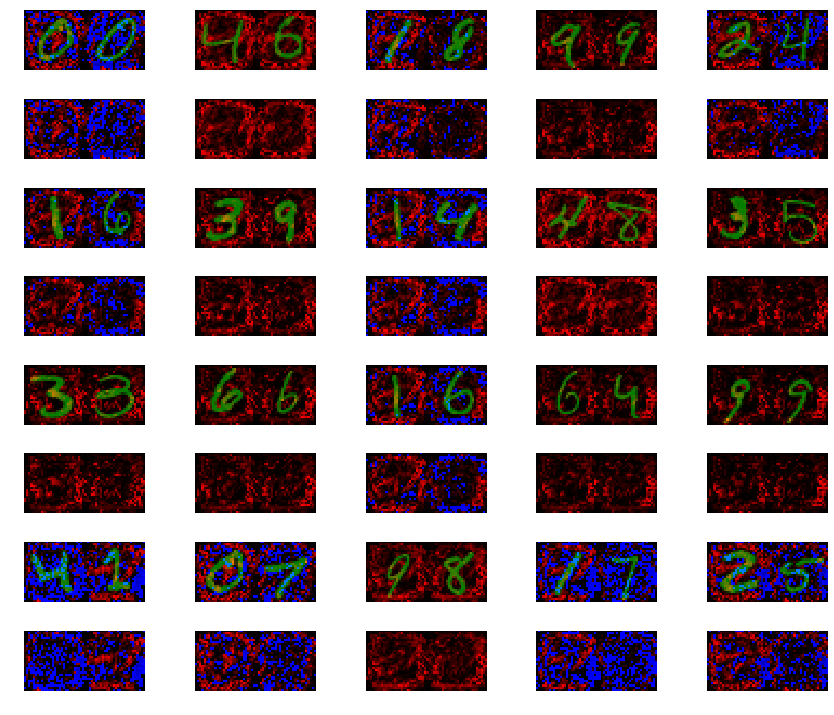

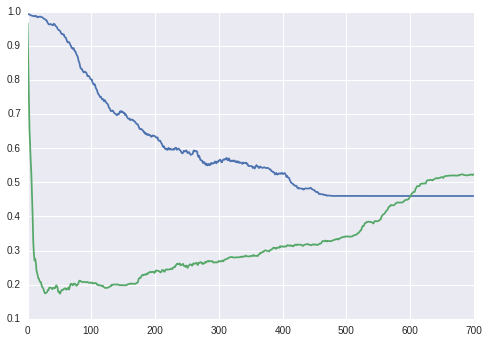

In [24]:
from braindecode.analysis.heatmap import create_heatmap_fn
dense_model = np.load('data/mnist/two-digit/dense-elu-any-bias.pkl')

heatmap_fn = create_heatmap_fn(lasagne.layers.get_all_layers(dense_model)[1:], 
                               ['z_b', 'a_b_sign_switch'], pool_by_grad=True,
                               min_in=0, max_in=1., a=1.2,b=0.2, biases=True,
                              use_output_as_relevance=True)

pred_fn = create_pred_fn(dense_model)
compute_show_heatmaps(heatmap_fn, pred_fn, X_train_flat_both,
                      X_train_topo_both, y_train_both,
                     i_last_trial=20)
show_heatmap_accuracy(heatmap_fn, pred_fn,
                      X_train_flat_both, y_train_both)

Mean Std over heatmaps: 0.5  (0.2)
Mean difference first 100 positive pixels 0.10
Mean difference first 250 positive pixels 0.06


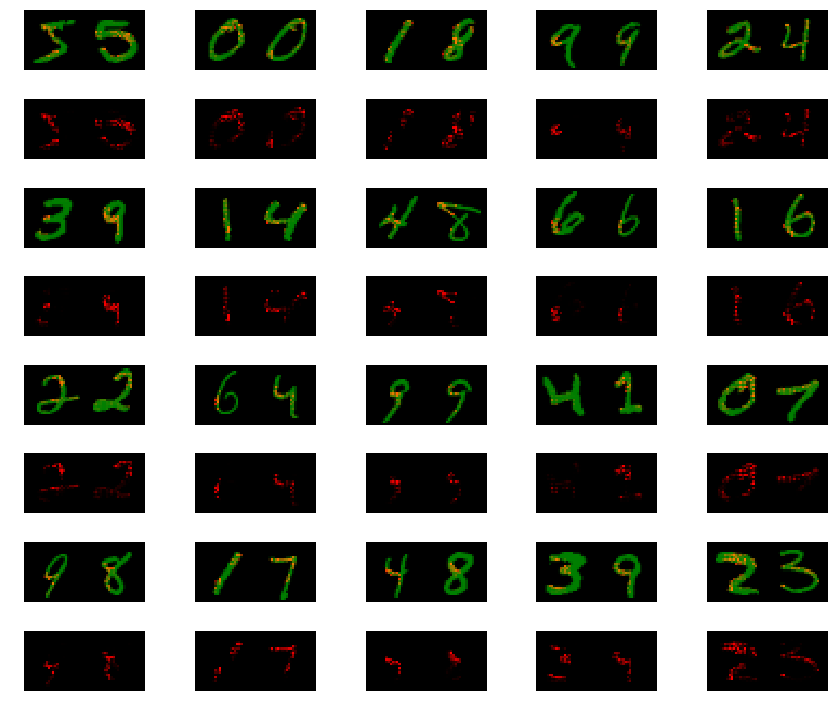

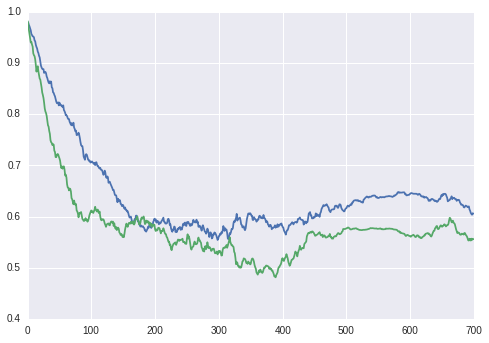

In [12]:
from braindecode.analysis.heatmap import create_heatmap_fn
three_layer_model = load_model(with_elu=True)

heatmap_fn = create_heatmap_fn(lasagne.layers.get_all_layers(three_layer_model)[1:], 
                               ['a_b', 'a_b_in_plus'], pool_by_grad=True,
                               min_in=0, max_in=1., a=1,b=0., biases=True,
                              use_output_as_relevance=True)

pred_fn = create_pred_fn(three_layer_model)
compute_show_heatmaps(heatmap_fn, pred_fn, X_train_flat_both,
                      X_train_topo_both, y_train_both,
                     i_last_trial=20)
show_heatmap_accuracy(heatmap_fn, pred_fn,
                      X_train_flat_both, y_train_both)

Mean Std over heatmaps: 1.0  (0.0)
Mean difference first 100 positive pixels 0.26
Mean difference first 250 positive pixels 0.14


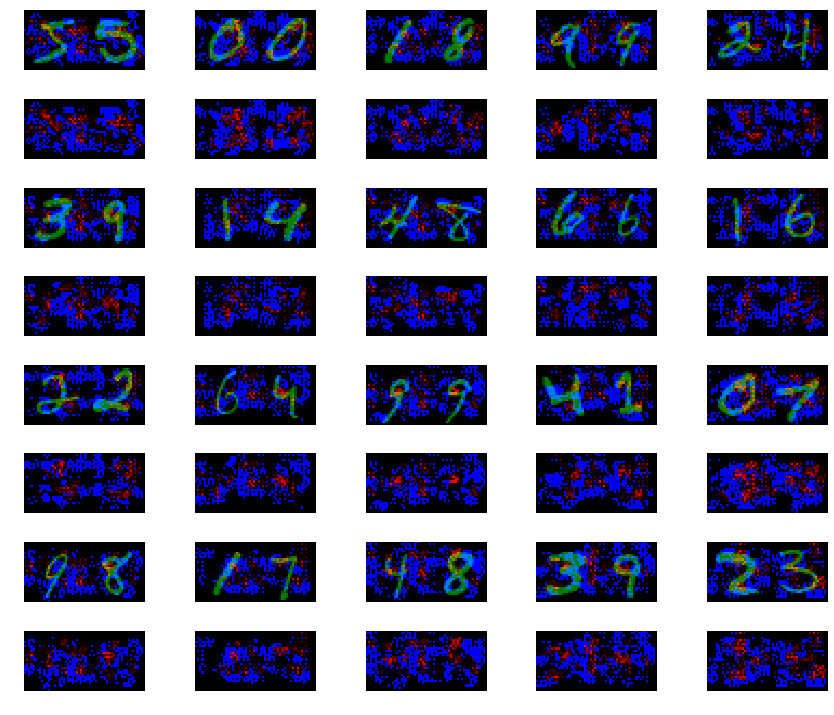

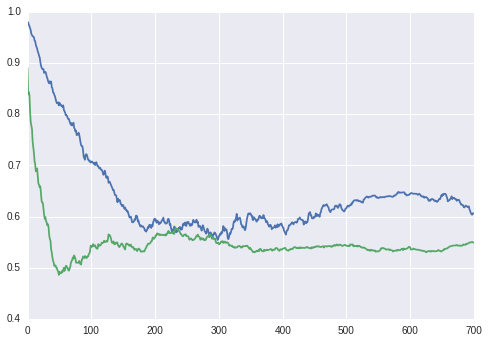

In [13]:
from braindecode.analysis.heatmap import create_heatmap_fn
three_layer_model = load_model(with_elu=True)

heatmap_fn = create_heatmap_fn(lasagne.layers.get_all_layers(three_layer_model)[1:], 
                               ['z_b', 'a_b_abs'], pool_by_grad=True,
                               min_in=0, max_in=1., a=1.2,b=0.2, biases=True,
                              use_output_as_relevance=True)

pred_fn = create_pred_fn(three_layer_model)
compute_show_heatmaps(heatmap_fn, pred_fn, X_train_flat_both,
                      X_train_topo_both, y_train_both,
                     i_last_trial=20)
show_heatmap_accuracy(heatmap_fn, pred_fn,
                      X_train_flat_both, y_train_both)

Mean Std over heatmaps: 1.0  (0.0)
Mean difference first 100 positive pixels 0.24
Mean difference first 250 positive pixels 0.13


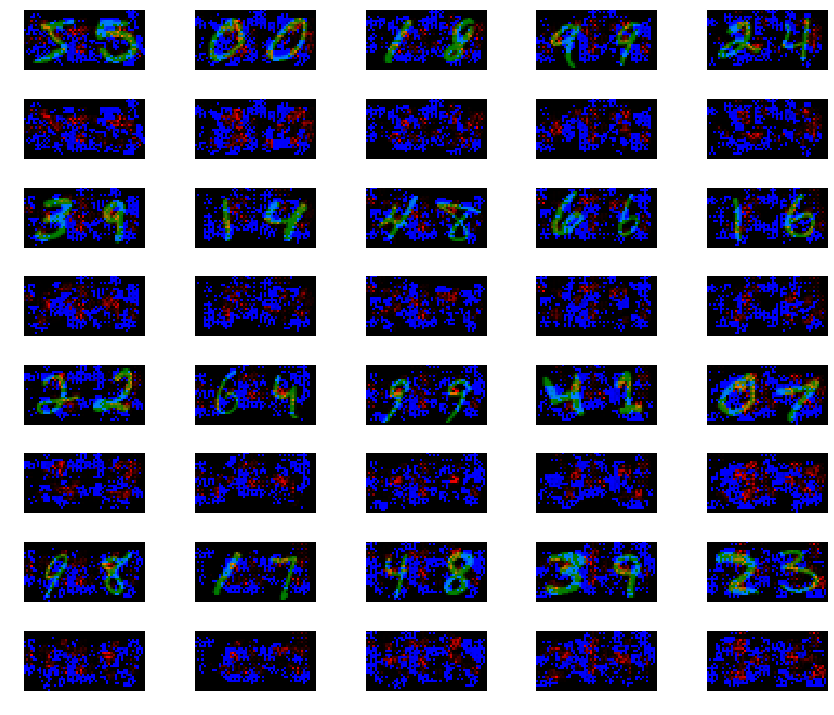

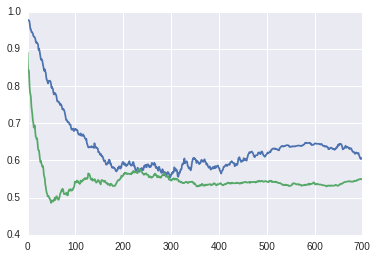

In [478]:
from braindecode.analysis.heatmap import create_heatmap_fn
three_layer_model = load_model(with_elu=True)

heatmap_fn = create_heatmap_fn(lasagne.layers.get_all_layers(three_layer_model)[1:], 
                               ['z_b', 'a_b_abs'], pool_by_grad=True,
                               min_in=0, max_in=1., a=1.2,b=0.2, biases=True,
                              use_output_as_relevance=True)

pred_fn = create_pred_fn(three_layer_model)
compute_show_heatmaps(heatmap_fn, pred_fn, X_train_flat_both,
                      X_train_topo_both, y_train_both,
                     i_last_trial=20)
show_heatmap_accuracy(heatmap_fn, pred_fn,
                      X_train_flat_both, y_train_both)

In [8]:
# Check correctness
from braindecode.veganlasagne.layers import create_pred_fn

def eval_model(model, X):
    pred_fn = create_pred_fn(model)
    preds = pred_fn(X)

    print(np.sum(np.argmax(preds,axis=1) == y_train_both) / float(len(X)))
    
